In [ ]:
# ==== IMPORTS ====
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import librosa
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# ==== AUDIO PREPROCESSING ====
def load_audio(audio, max_length=100):
    y, sr = librosa.load(audio, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = mfcc.T
    if mfcc.shape[0] > max_length:
        mfcc = mfcc[:max_length, :]
    else:
        pad_width = max_length - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    return mfcc

# ==== IMAGE CNN MODEL ====
def build_cnn(input_shape=(128, 128, 3)):
    image_input = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    cnn_model = Model(image_input, x)
    return cnn_model

def build_image_model():
    cnn_model = build_cnn()
    x = Dense(1, activation='sigmoid')(cnn_model.output)
    model = Model(inputs=cnn_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ==== TRAIN IMAGE MODEL ====
def train_image_model():
    model = build_image_model()
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )

    dataset_path = os.path.join(os.getcwd(), 'datasets', 'ASDPROJECTIMAGE')

    train_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )

    val_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
    ]

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=callbacks
    )

    model.save(os.path.join('models', 'asd_image_model.keras'))

# ==== AUDIO LSTM MODEL ====
def build_lstm(input_shape=(100, 40)):
    audio_input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(audio_input)
    x = LSTM(64)(x)
    x = Dense(128, activation='relu')(x)
    lstm_model = Model(audio_input, x)
    return lstm_model

def build_audio_model():
    lstm_model = build_lstm()
    x = Dense(1, activation='sigmoid')(lstm_model.output)
    model = Model(inputs=lstm_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ==== TRAIN AUDIO MODEL ====
def train_audio_model():
    dataset_path = os.path.join(os.getcwd(), 'datasets', 'ASDPROJECTVOICE')
    labels = os.listdir(dataset_path)
    label_map = {label: idx for idx, label in enumerate(labels)}

    X, y = [], []

    for label in labels:
        files_list = os.listdir(os.path.join(dataset_path, label))
        for file in files_list:
            audio_path = os.path.join(dataset_path, label, file)
            mfcc = load_audio(audio_path)
            X.append(mfcc)
            y.append(label_map[label])

    X = np.array(X)
    y = np.array(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_audio_model()

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
    ]

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=callbacks
    )

    model.save(os.path.join('models', 'asd_audio_model.keras'))

# ==== LOCAL PREDICTION FUNCTION ====
def predict_local(image_path, audio_path):
    # Load pre-trained models
    image_model = load_model(os.path.join('models', 'asd_image_model.keras'))
    audio_model = load_model(os.path.join('models', 'asd_audio_model.keras'))

    class_labels = ['Non-Autistic', 'Autistic']

    # ==== Image Prediction ====
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    image_prediction = image_model.predict(img_array)[0][0]
    predicted_class_img = 1 if image_prediction > 0.5 else 0
    confidence_img = image_prediction if predicted_class_img == 1 else 1 - image_prediction
    image_label = class_labels[predicted_class_img]

    # ==== Audio Prediction ====
    audio_data = np.expand_dims(load_audio(audio_path), axis=0)

    audio_prediction = audio_model.predict(audio_data)[0][0]
    predicted_class_audio = 1 if audio_prediction > 0.5 else 0
    confidence_audio = audio_prediction if predicted_class_audio == 1 else 1 - audio_prediction
    audio_label = class_labels[predicted_class_audio]

    # ==== Show Results ====
    img_display = Image.open(image_path)
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(f"Image Prediction: {image_label} ({confidence_img * 100:.2f}% confidence)")
    plt.show()

    print(f"Audio Prediction: {audio_label} ({confidence_audio * 100:.2f}% confidence)")

# ==== MAIN CALLS ====
# To Train:
# train_image_model()
# train_audio_model()

# To Predict:
# predict_local('path/to/your/image.jpg', 'path/to/your/audio.wav')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
        train_image_model()


Found 20 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4500 - loss: 1.1591 - val_accuracy: 0.5000 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.8302 - val_accuracy: 1.0000 - val_loss: 0.6641 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8500 - loss: 0.3320 - val_accuracy: 0.5000 - val_loss: 0.6910 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9000 - loss: 0.4373 - val_accuracy: 0.5000 - val_loss: 0.7078 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8500 - loss: 0.7488 - val_accuracy: 0.5000 - val_loss: 0.7010 - learning_rate: 1.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9000 - loss: 0.3626 - val_accuracy: 0.5000 - val_loss: 0.6919 - learning_rate: 5.0000e-05
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9500 - loss: 0.2550 - val_accurac

In [ ]:
train_audio_model()

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6000 - loss: 0.6746 - val_accuracy: 0.3333 - val_loss: 0.7134 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6000 - loss: 0.6664 - val_accuracy: 0.3333 - val_loss: 0.7097 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6000 - loss: 0.6585 - val_accuracy: 0.3333 - val_loss: 0.7063 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6000 - loss: 0.6508 - val_accuracy: 0.3333 - val_loss: 0.7031 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6000 - loss: 0.6435 - val_accuracy: 0.3333 - val_loss: 0.7001 - learning_rate: 1.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6000 - loss: 0.6365 - val_accuracy: 0.3333 - val_loss: 0.6972 - learning_rate: 1.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6000 - loss: 0.

Please upload an image (jpg, jpeg, png)...


Saving 3.jpg to 3 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


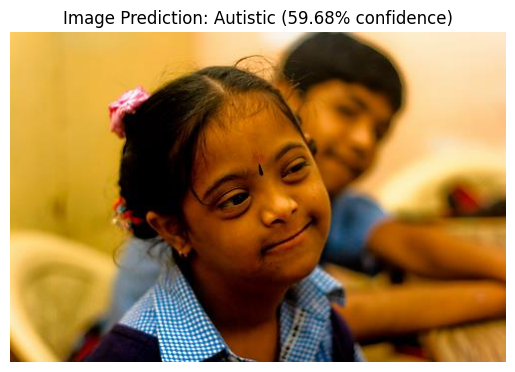

Now upload an audio file (wav, mp3)...


Saving common_voice_ta_36552320.mp3 to common_voice_ta_36552320.mp3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Audio Prediction: Autistic (57.31% confidence)


In [ ]:
upload_and_predict()